In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Topic: EX2 - Turbofan RUL Prediction
**Task**: Predict the remaining useful life (RUL) of turbofan engines based on given sensor data (time series data). It is a regression problem.
**Data**: Turbofan engine degradation simulation data (NASA) - [Link](https://data.nasa.gov/dataset/Turbofan-Engine-Degradation-Simulation-Data-Set/vrks-gjie). See also in the topic [introduction notebook](https://github.com/nina-prog/damage-propagation-modeling/blob/2fb8c1a1102a48d7abbf04e4031807790a913a99/notebooks/Turbofan%20remaining%20useful%20life%20Prediction.ipynb).

**Subtasks**:
1. Perform a deep **exploratory data analysis (EDA)** on the given data.
2. Implement a more efficient **sliding window method** for time series data analysis.
3. Apply **traditional machine learning methods** (SOTA) to predict the remaining useful life. Includes data preparation, feature extraction, feature selection, model selection, and model parameter optimization. -> 🎯 **Focus on this task** data preparation and feature selection (feature extraction part of sliding window method).
4. Create **neural network models** to predict the remaining useful life. Includes different architectures like Convolutional Neural Networks (CNN), Recurrent Neural Networks (RNN), or Attention Models. Note: You can search for SOTA research papers and reproduce current state-of-the-art models.


# Imports + Settings

In [3]:
# third-party libraries
import pandas as pd
import numpy as np
import os
from typing import List, Union
import time
from tqdm.notebook import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats

In [58]:
# source code
from src.utils import load_data, load_config
from src.rolling_window_creator import RollingWindowDatasetCreator
from src.data_cleaning import identify_missing_values, identify_single_unique_features, format_dtype

In [5]:
# settings
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set(rc={"figure.dpi":100, 'savefig.dpi':200})
sns.set_context('notebook')

In [6]:
np.random.seed(42)

# Paths

In [7]:
os.chdir("../") # set working directory to root of project
#os.getcwd() # check current working directory

In [8]:
PATH_TO_CONFIG = "configs/config.yaml"

# Load config + Data

In [61]:
config = load_config(PATH_TO_CONFIG) # config is dict

In [62]:
%%time
train_data, test_data, test_RUL_data = load_data(config_path=PATH_TO_CONFIG, dataset_num=4)

2024-05-17 21:32:15 [src.utils:54] [INFO] >>>> Loading data set 4...
2024-05-17 21:32:16 [src.utils:83] [INFO] >>>> Loaded raw data for dataset 4.
2024-05-17 21:32:16 [src.utils:84] [INFO] >>>> Train Data: (61249, 26)
2024-05-17 21:32:16 [src.utils:85] [INFO] >>>> Test Data: (41214, 26)
2024-05-17 21:32:16 [src.utils:86] [INFO] >>>> Test RUL Data: (248, 1)
CPU times: total: 234 ms
Wall time: 1.01 s


In [63]:
# count unit numbers in test set
print(f"Number of unique unit numbers in test set: {test_data['UnitNumber'].nunique()}")
# count min number of cycles in test set for each unit number --> window size must be in the range of these values, for example a window size of 10 would be too large if there is a unit number with only 10 cycles
print("Min number of cycles in test set for a unit number: ", test_data.groupby("UnitNumber")["Cycle"].count().min())

Number of unique unit numbers in test set: 248
Min number of cycles in test set for a unit number:  19


In [64]:
%%time
# 1 min 35 s without clean before window generation -> 59.4s with clean before window generation (fewer features)
creator = RollingWindowDatasetCreator(column_id="UnitNumber",
                                      column_sort="Cycle",
                                      max_timeshift=config["preprocessing"]["max_window_size"],
                                      min_timeshift=config["preprocessing"]["min_window_size"],
                                      feature_extraction_mode='minimal')
X_train, y_train, X_test, y_test = creator.create_rolling_windows_datasets(train_data, test_data, test_RUL_data)

2024-05-17 21:32:19 [src.rolling_window_creator:73] [INFO] >>>> Creating rolling windows for train data...


Rolling: 100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


2024-05-17 21:32:32 [src.rolling_window_creator:79] [INFO] >>>> Extracting features for train data...


Feature Extraction: 100%|██████████| 40/40 [03:47<00:00,  5.69s/it]


2024-05-17 21:36:51 [src.rolling_window_creator:87] [INFO] >>>> Calculating target for train data...
2024-05-17 21:36:51 [src.rolling_window_creator:73] [INFO] >>>> Creating rolling windows for test data...


Rolling: 100%|██████████| 38/38 [00:08<00:00,  4.29it/s]


2024-05-17 21:37:00 [src.rolling_window_creator:79] [INFO] >>>> Extracting features for test data...


Feature Extraction: 100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


2024-05-17 21:37:04 [src.rolling_window_creator:103] [INFO] >>>> Datasets created successfully.
2024-05-17 21:37:04 [src.rolling_window_creator:104] [INFO] >>>> Shape of X_train: (60004, 240)
2024-05-17 21:37:04 [src.rolling_window_creator:105] [INFO] >>>> Shape of y_train: (60004, 1)
2024-05-17 21:37:04 [src.rolling_window_creator:106] [INFO] >>>> Shape of X_test: (248, 240)
2024-05-17 21:37:04 [src.rolling_window_creator:107] [INFO] >>>> Shape of y_test: (248, 1)
CPU times: total: 2min 35s
Wall time: 4min 45s


In [ ]:
# load saved preprocessed data from pickle
#X_train = pd.read_pickle("data/processed/ex2_X_train_20240512-155504.pkl")
#y_train = pd.read_pickle("data/processed/ex2_y_train_20240512-155504.pkl")
#X_test = pd.read_pickle("data/processed/ex2_X_test_20240512-155504.pkl")
#y_test = pd.read_pickle("data/processed/ex2_y_test_20240512-155504.pkl")

# Data Preprocessing

## 1. Clean Data
* format column types - only necessary if categorical columns are present ✅
* handle missing values ✅
* handle single unique values ✅
* handle duplicates ✅
* handle outliers
* feature engineering
    * group features with rarely occurring realizations into buckets


### Format Column Types

In [66]:
formatted_df = format_dtype(train_data)

2024-05-17 21:41:34 [src.data_cleaning:70] [INFO] >>>> Found 0 categorical columns: []


### Handle Missing Values

In [67]:
missing_features = identify_missing_values(train_data, threshold=0.1)
missing_features

2024-05-17 21:41:43 [src.data_cleaning:27] [INFO] >>>> Found 0 features with missing values above the threshold of 0.1.


[]

In [68]:
# drop features with missing values
train_data.drop(missing_features, axis=1, inplace=True)
test_data.drop(missing_features, axis=1, inplace=True)

### Handle Single Unique Values

In [69]:
single_unique_features = identify_single_unique_features(train_data)
single_unique_features

2024-05-17 21:41:51 [src.data_cleaning:47] [INFO] >>>> Found 0 features with only a single unique value.


[]

In [70]:
# drop features with single unique values
train_data.drop(single_unique_features, axis=1, inplace=True)
test_data.drop(single_unique_features, axis=1, inplace=True)

# Handle duplicates

In [72]:
# get number of duplicates
print(f"Number of duplicates in train data: {train_data.duplicated().sum()}")
print(f"Number of duplicates in test data: {test_data.duplicated().sum()}")
# drop duplicates
train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)

Number of duplicates in train data: 0
Number of duplicates in test data: 0


### Handle Outliers
Possible Methods to investigate:
* Z-Score
* IQR
* Winsorization
* Isolation Forest ❌
* Local Outlier Factor (LOF) ✅
* Elliptic Envelope

#### Z-Score
**Use Case**: Normally distributed data
**Assumption**: Assumes that the data follows a normal distribution. It identifies outliers based on how many standard deviations away from the mean a data point is.



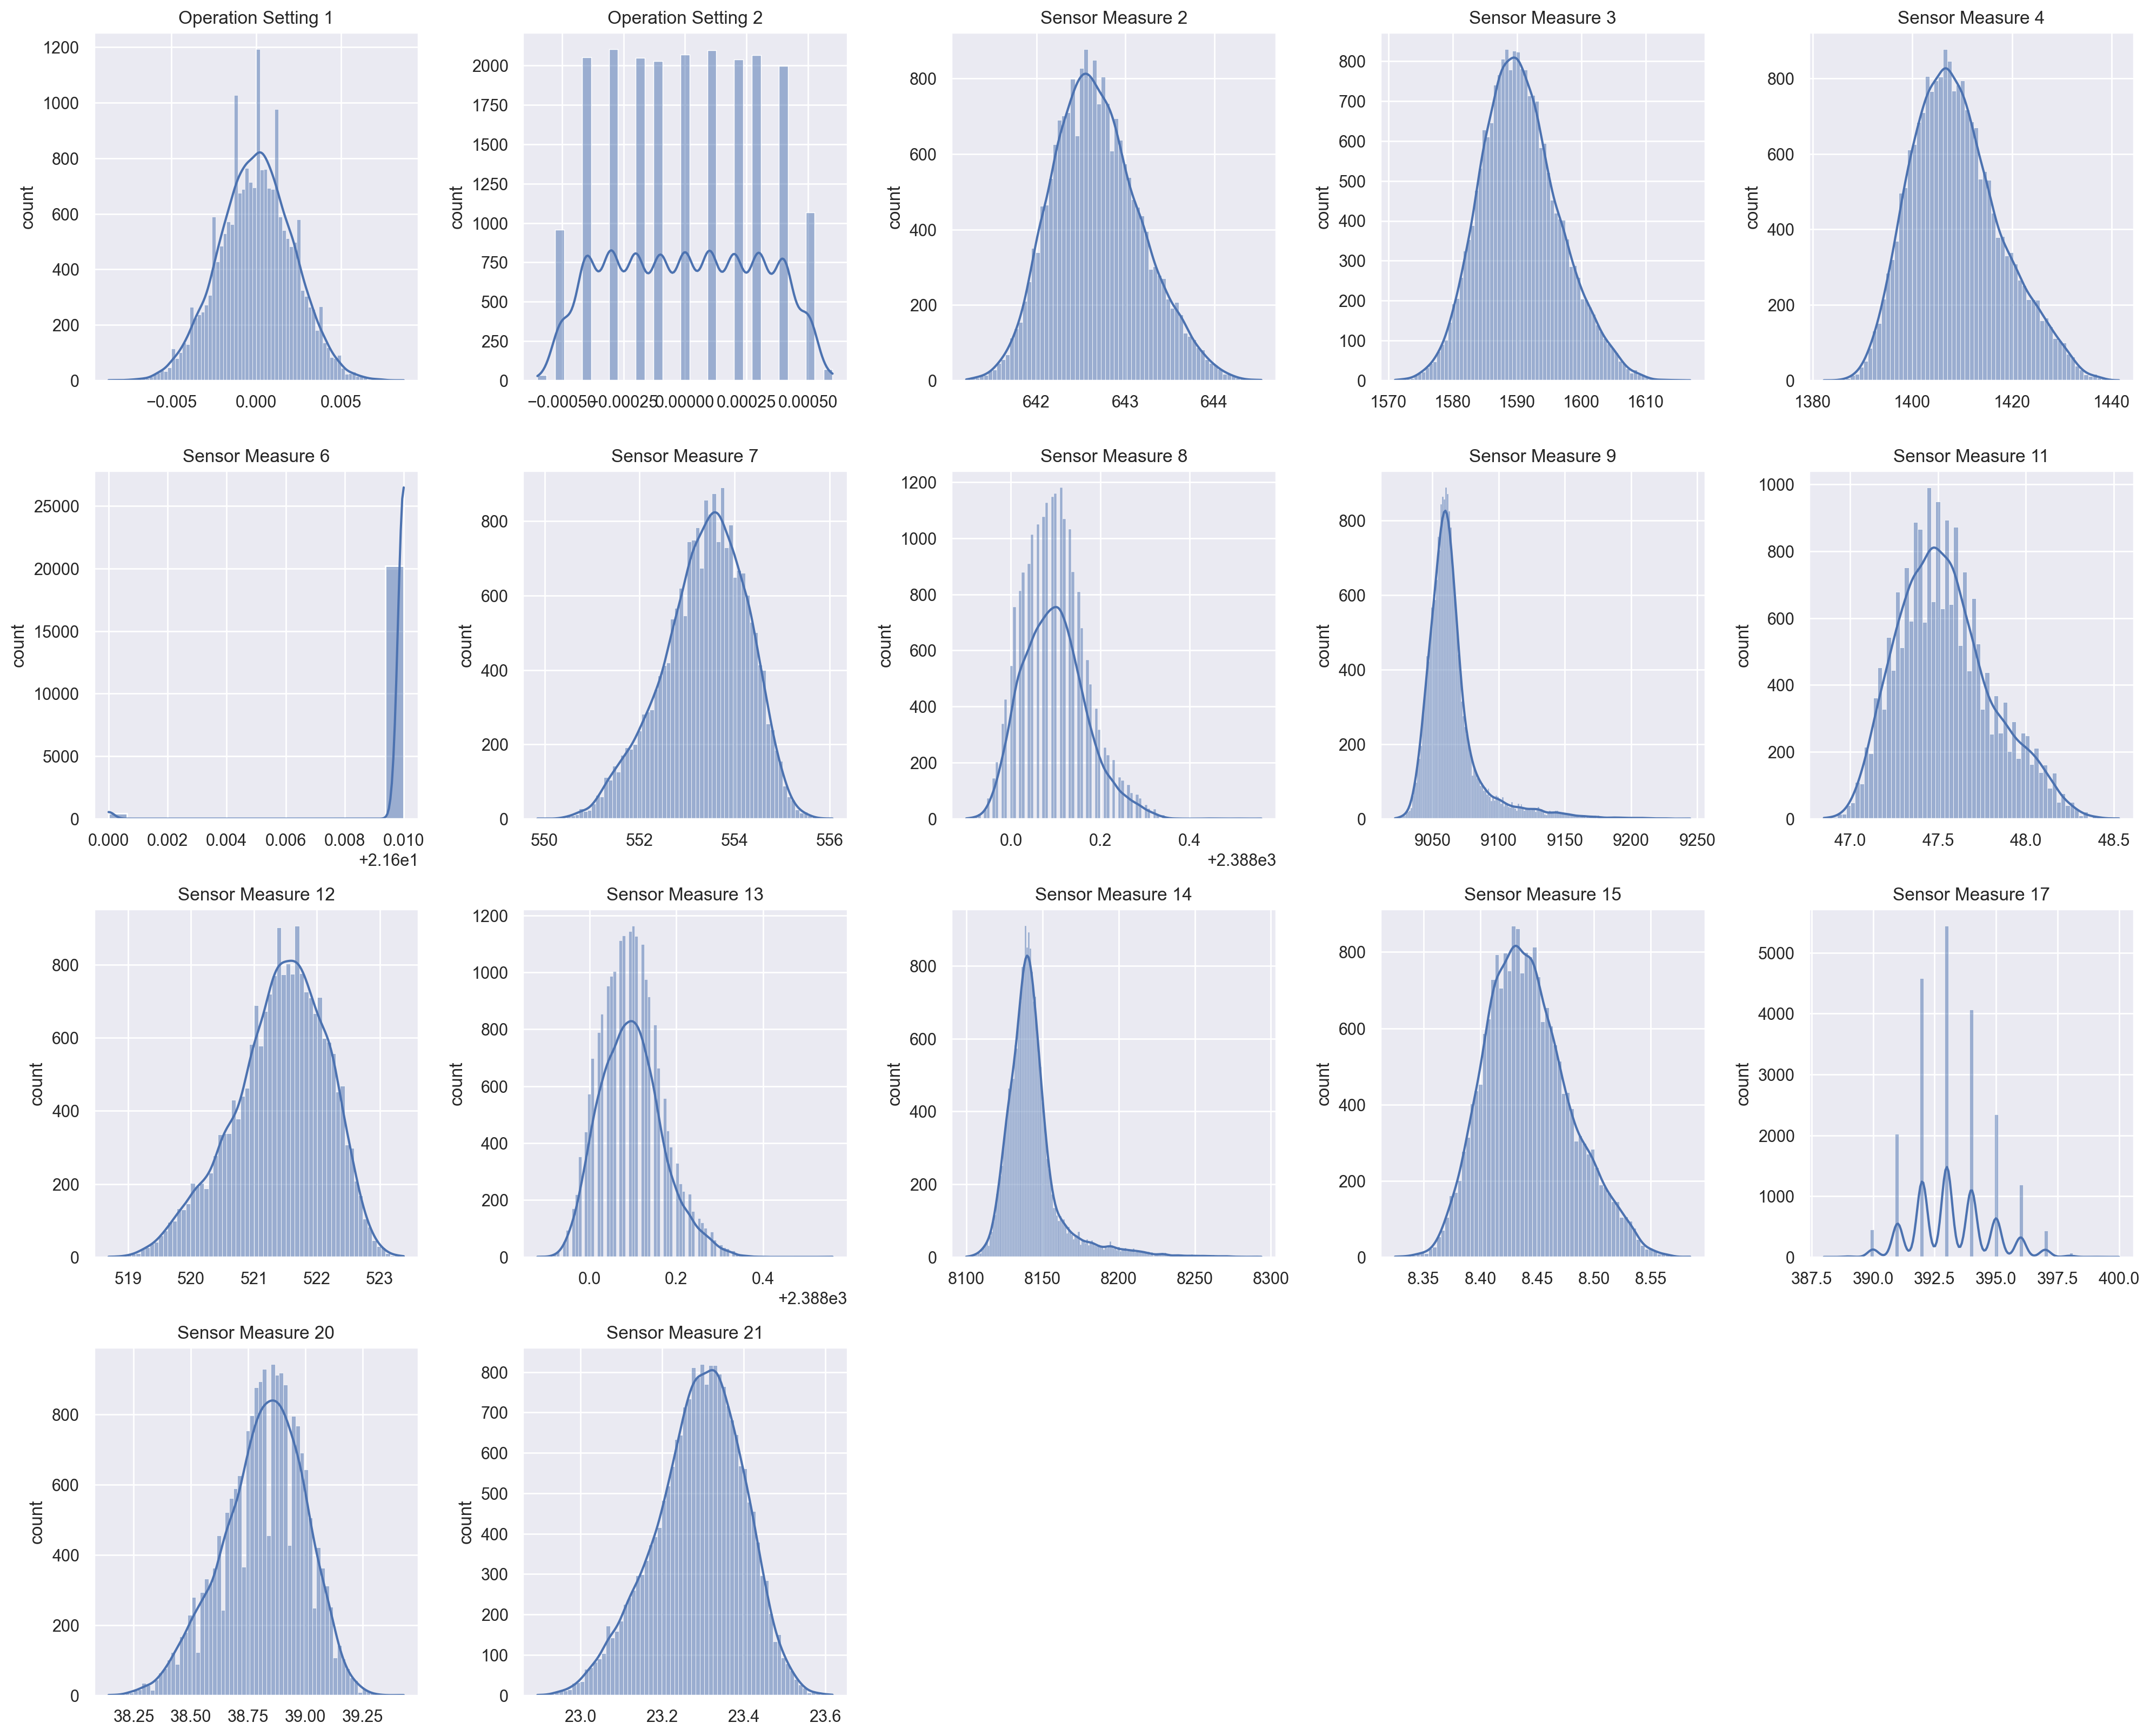

In [64]:
# visual inspection
plt.figure(figsize=(20, 20))
for i, col in enumerate(train_data.drop(['UnitNumber', 'Cycle'], axis = 1).columns):
    plt.subplot(5, 5, i+1)
    sns.histplot(train_data[col], kde=True)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('count')
plt.tight_layout()
plt.show()

Findings:
* ```Sensor Measure 6``` is highly skewed -> **investigate further**(drop feature), indicating non-normal distribution
* ```Operation Setting 2``` and ```Sensor Measure 17``` have multiple peaks and seem to only have a few unique numeric values -> **investigate further** (group into buckets, drop, etc.), indicating non-normal distribution
* All other features exhibit approximately normal distributions, indicated by a single peak with bell-shaped curves.

In [ ]:
# Step 2: Summary Statistics
summary_stats = {'Mean': np.mean(train_data, axis=0),
                 'Median': np.median(train_data, axis=0),
                 'Standard Deviation': np.std(train_data, axis=0),
                 'Skewness': stats.skew(train_data, axis=0),
                 'Kurtosis': stats.kurtosis(train_data, axis=0)}

for stat, values in summary_stats.items():
    print(f'{stat}: {values}')

#### IQR
**Use Case**: Non-normally distributed data
**Assumption**: Suitable for data that may not follow a normal distribution. It defines outliers based on the spread of the middle 50% of the data, rather than assuming a specific distribution.



#### Winsorization
**Use Case**: Non-normally distributed data, when you need to reduce the influence of outliers without removing data points.
**Assumption**: It doesn't assume any specific distribution but instead modifies extreme values to be less influential while preserving the data's overall distribution.

#### Isolation Forest
**Use Case**: High-dimensional data
**Assumption**: Effective for high-dimensional data where traditional distance-based methods might struggle. It works by isolating outliers in a way that separates them from the rest of the data using a tree-based approach.

* --> High-dimensional data refers to data sets for which the number of variables or dimensions $p$ is much larger than the number of observations $n$, typically $p >> n$. Source: Giraud, C. (2015). *Introduction to High-Dimensional Statistics*. CRC Press.
* ❌ **Not** our case (Shape of X_train: (20131, 170))

#### Local Outlier Factor (LOF)
**Use Case**: Effective for datasets with varying densities.
**Assumption**: LOF is useful for datasets where the density of points varies across the dataset. It calculates the local density around each data point and identifies outliers as points with significantly lower densities compared to their neighbors.

* --> LOF well-suited for our dataset, which exhibits heterogeneous density distributions (see plots).
* ✅ **Use LOF for outlier detection.**

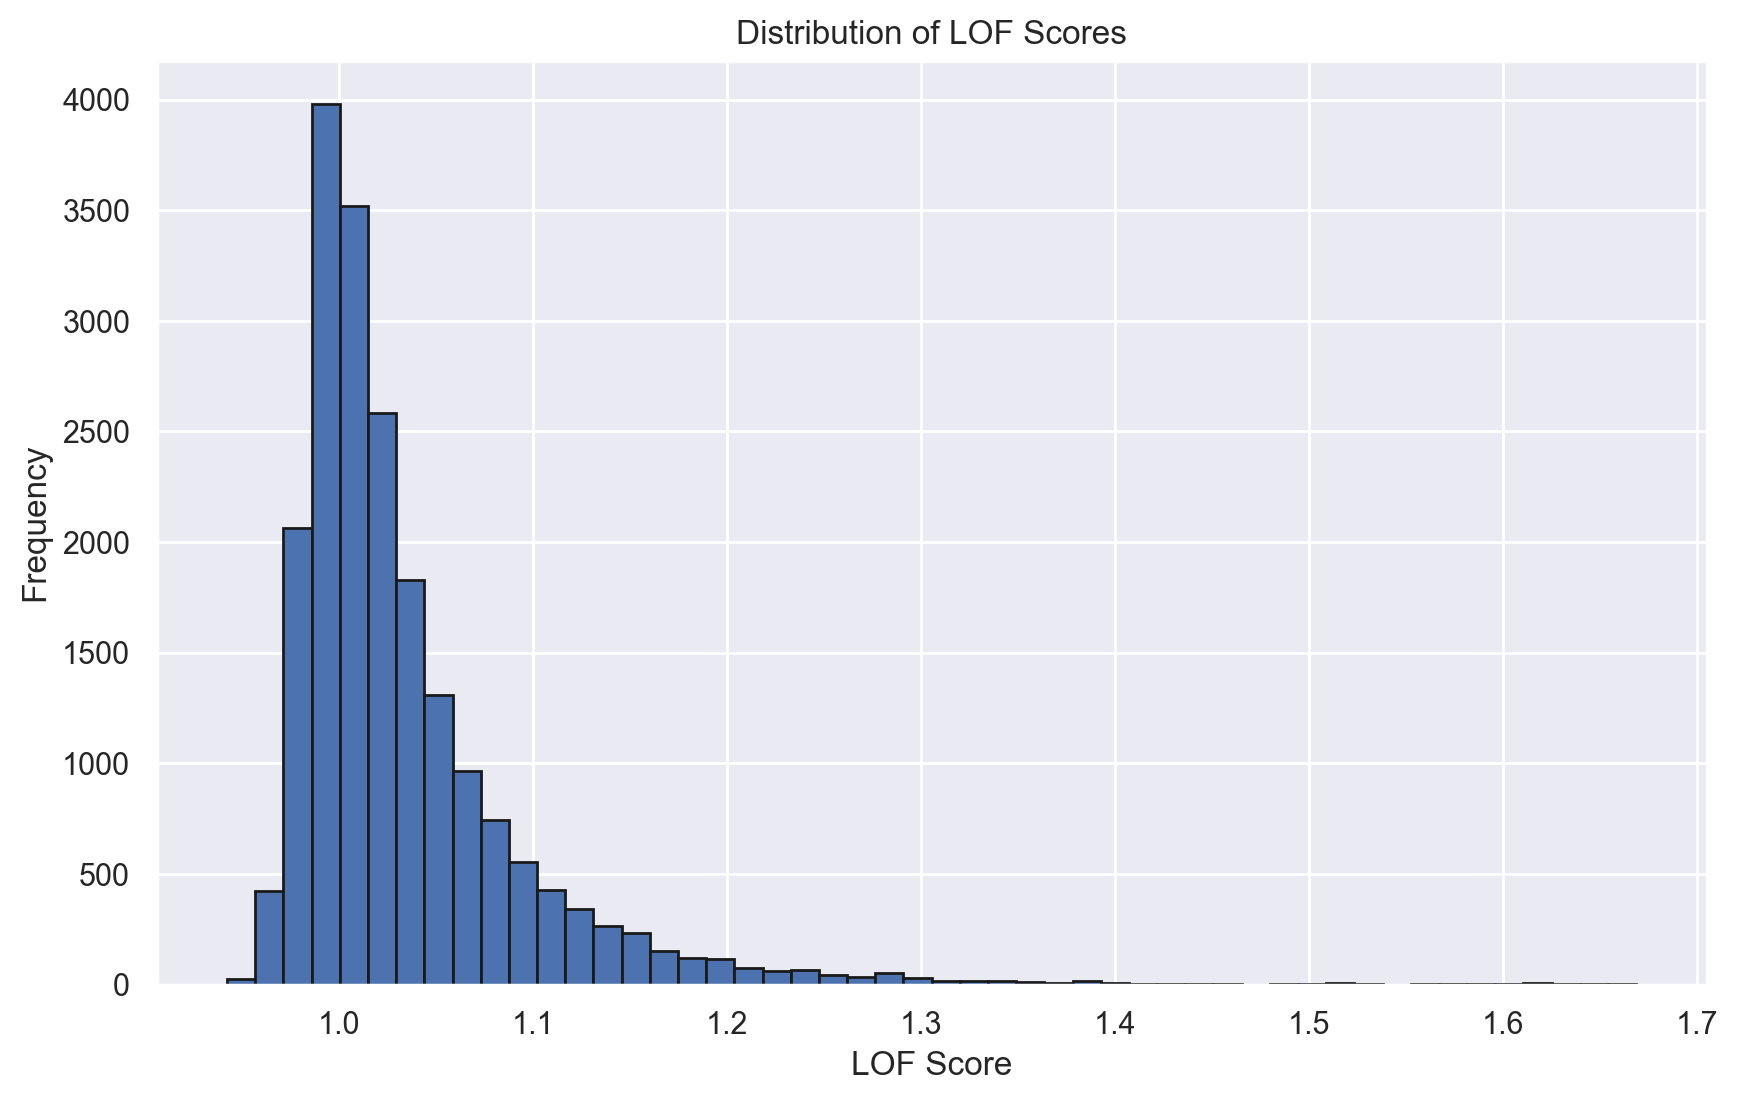

In [41]:
# fit LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Adjust parameters as needed
lof.fit(X_train)

# calc LOF scores
lof_scores = -lof.negative_outlier_factor_

# plot
plt.figure(figsize=(10, 6))
plt.hist(lof_scores, bins=50, edgecolor='k')
plt.xlabel('LOF Score')
plt.ylabel('Frequency')
plt.title('Distribution of LOF Scores')
plt.grid(True)
plt.show()

Findings:
* Presence of scores below 1 indicates regions of exceptionally high data density. --> No outliers in these regions.
* Peak around 1.0 indicates regions of average data density, clustered around a normal density level.
* Gradual decrease in frequency suggests lower density regions.
* Sharp drop at 1.3 may represent areas of lower data density, where outliers may start to emerge.

#### Elliptic Envelope
**Use Case**: Assumes the data is normally distributed and identifies points that are far from the center. Suitable for multivariate normally distributed data.
**Assumption**: Assumes the data is multivariate normally distributed and aims to identify outliers by fitting an ellipse around the central data points. Points outside this ellipse are considered outliers.

In [ ]:
def remove_outliers(df: pd.DataFrame, method: str = 'winsorize', ignore_columns: List[str] = None,
                    threshold: float = 1.5, contamination: float = 0.05, soft_drop: bool = False):
    """
    Handle outliers in a DataFrame using various methods.

    :param df: The input DataFrame.
    :type df: pd.DataFrame
    :param method: The method to use for handling outliers. Choose from 'iqr', 'zscore', 'winsorize',
    'isolation_forest', 'lof', 'elliptic_envelope'.
    :type method: str
    :param ignore_columns: The columns to ignore when handling outliers.
    :type ignore_columns: list
    :param threshold: The threshold for the outlier detection method.
    :type threshold: float
    :param contamination: The proportion of outliers which are
    :type contamination: float
    :param soft_drop: Boolean to indicate whether to softly drop outliers.
    :type soft_drop: bool

    :return: The DataFrame with outliers removed.
    :rtype: pd.DataFrame

    """
    if ignore_columns is None:
        ignore_columns = []

    df_out = df.copy()

    if method == 'iqr':
        df_out = remove_outliers_iqr(df, threshold, soft_drop)
    elif method == 'zscore':
        df_out = remove_outliers_zscore(df, soft_drop)
    elif method == 'winsorize':
        df_out = remove_outliers_winsorize(df, ignore_columns, contamination)
    elif method in ['isolation_forest', 'lof', 'elliptic_envelope']:
        df_out = remove_outliers_machine_learning(df, method, contamination, soft_drop)
    else:
        raise ValueError(
            "Unsupported method: Choose from 'iqr', 'zscore', 'winsorize', 'isolation_forest', 'lof', "
            "'elliptic_envelope'")

    return df_out


def remove_outliers_iqr(df, threshold, soft_drop):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    if soft_drop:
        outlier_proportion = ((df < lower_bound) | (df > upper_bound)).mean(axis=1)
        return df[~((df < lower_bound) | (df > upper_bound) & (outlier_proportion > 0.3)).any(axis=1)]
    else:
        return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]


def remove_outliers_zscore(df, soft_drop):
    z_scores = zscore(df)
    threshold = 3

    if soft_drop:
        return df[(np.abs(z_scores) < threshold).all(axis=1) & (np.abs(z_scores) < threshold).mean(axis=1) > 0.3]
    else:
        return df[(np.abs(z_scores) < threshold).all(axis=1)]


def remove_outliers_winsorize(df, ignore_columns, contamination):
    return df.apply(
        lambda x: winsorize(x, limits=[contamination, contamination]) if x.name not in ignore_columns else x)


def remove_outliers_machine_learning(df, method, contamination, soft_drop):
    outlier_detector = None
    if method == 'isolation_forest':
        outlier_detector = IsolationForest(contamination=contamination)
    elif method == 'lof':
        outlier_detector = LocalOutlierFactor(contamination=contamination)
    elif method == 'elliptic_envelope':
        outlier_detector = EllipticEnvelope(contamination=contamination)

    yhat = outlier_detector.fit_predict(df)

    if soft_drop:
        return df[yhat != -1 & ((yhat != -1).mean(axis=1) > 0.3)]
    else:
        return df[yhat != -1]

#### Summary of all preprocessing steps in one function

# 2. Post-Windowing Preprocessing (if necessary)
Additional preprocessing steps after feature extraction if needed
* handle correlated features

## 3. Feature Selection

Orientation:
![Feature Selection](https://machinelearningmastery.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png)

Potential Feature Selection Methods:
* Supervised:
    * Filter Methods:
        * Numerical Input, Numerical Output:
                * Pearson’s correlation coefficient (linear)
                * Spearman’s rank coefficient (nonlinear)
        * --> Using Pearson’s Correlation Coefficient via the f_regression() function and SelectKBest (feature selection strategy).
        * --> Using Mutual Information via the mutual_info_regression() function and SelectKBest (feature selection strategy).
    * Wrapper Methods:
        * Recursive Feature Elimination (RFE)
        * --> Using RFE with a linear model (e.g., linear regression).

# 4. Dimensionality Reduction
Only if certain number of features is above a certain threshold.
